# 04-cluster.ipynb  
## Clustering de Categorias de Produto  
**Objetivo**: agrupar categorias que apresentam comportamentos semelhantes em termos de ticket médio, nota média de review e número de pedidos.

## Instalação do scikit-learn  
Para executar o clustering, precisamos do scikit-learn. Execute o próximo bloco para instalar.


In [7]:
!pip install scikit-learn


In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

%matplotlib inline


In [2]:
# 1) Carregar o dataset limpo
df = pd.read_csv("../data/ecommerce_clean.csv", parse_dates=["order_purchase_timestamp"])

# 2) Criar agregados por categoria
agg = df.groupby("product_category_name").agg(
    ticket_medio      = ("total_price", "mean"),
    nota_media        = ("review_score", "mean"),
    pedidos_contagem  = ("order_id", "nunique")
).dropna()

print("Categorias agregadas:", agg.shape)
display(agg.head())


Categorias agregadas: (73, 3)


,ticket_medio,nota_media,pedidos_contagem
product_category_name,,,
agro_industria_e_comercio,342.553883,4.087379,177
alimentos,57.577455,4.262834,441
alimentos_bebidas,55.475535,4.369004,221
artes,120.087817,4.082051,195
artes_e_artesanato,75.583750,4.125000,23


## 2. Preparação para clustering  
Padronizamos as variáveis para que tenham média zero e variância 1.

In [3]:
scaler = StandardScaler()
X = scaler.fit_transform(agg)

print("Matriz padronizada:", X.shape)


Matriz padronizada: (73, 3)


## 3. Escolha do número de clusters  
Calculamos inércia (elbow) e score de silhouette para k de 2 a 8.


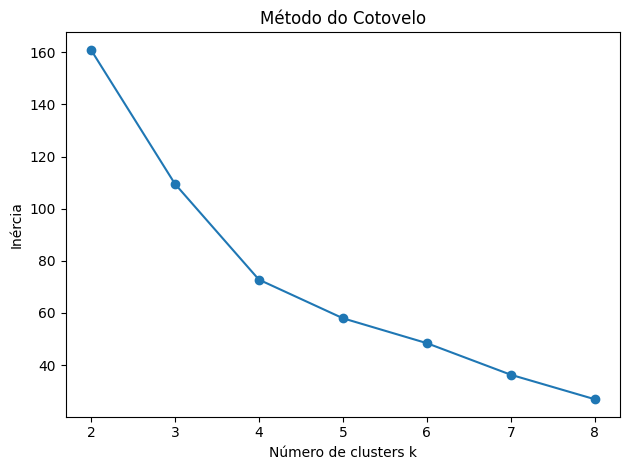

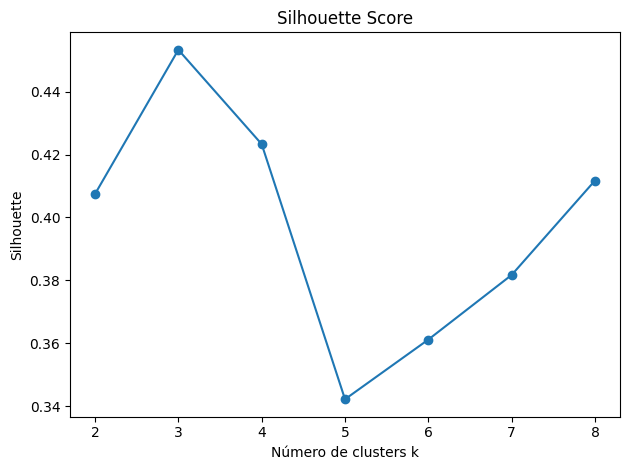

In [4]:
inertia = []
sil_scores = []
K = range(2, 9)

for k in K:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(X)
    inertia.append(km.inertia_)
    sil_scores.append(silhouette_score(X, labels))

# Plot elbow
plt.figure()
plt.plot(K, inertia, marker="o")
plt.title("Método do Cotovelo")
plt.xlabel("Número de clusters k")
plt.ylabel("Inércia")
plt.tight_layout()

# Plot silhouette
plt.figure()
plt.plot(K, sil_scores, marker="o")
plt.title("Silhouette Score")
plt.xlabel("Número de clusters k")
plt.ylabel("Silhouette")
plt.tight_layout()


## 4. Ajuste final do KMeans  
Escolha o k que fizer mais sentido (ex.: 3). Em seguida, atribua labels às categorias.


In [5]:
# Ajuste com o k escolhido (por exemplo, k=3)
k_final = 3
kmeans = KMeans(n_clusters=k_final, random_state=42, n_init=10)
agg["cluster"] = kmeans.fit_predict(X)

# Visualizar clusters
display(agg.sort_values("cluster").head(20))


,ticket_medio,nota_media,pedidos_contagem,cluster
product_category_name,,,,
agro_industria_e_comercio,342.553883,4.087379,177,0
fashion_esporte,70.650333,4.366667,26,0
telefonia_fixa,216.231250,3.758893,212,0
fashion_roupa_infanto_juvenil,74.278571,5.000000,7,0
fashion_roupa_masculina,83.618640,3.758065,106,0
fashion_underwear_e_moda_praia,73.275197,4.047619,117,0
flores,33.637576,4.419355,29,0
fraldas_higiene,40.561892,3.378378,25,0
industria_comercio_e_negocios,144.323811,4.125954,231,0


## 5. Interpretação dos Clusters  
Calculamos estatísticas agregadas para entender o perfil de cada grupo.


In [6]:
# Resumo por cluster
summary = agg.groupby("cluster").agg(
    ticket_medio_media   = ("ticket_medio",      "mean"),
    nota_media_media     = ("nota_media",        "mean"),
    pedidos_total        = ("pedidos_contagem",  "sum")
)
# Quantidade de categorias em cada cluster
summary["num_categorias"] = agg.groupby("cluster").size()
# Cria DataFrame com categoria e seu cluster
clusters_map = agg.reset_index()[["product_category_name", "cluster"]]

# Garante que a pasta data/ existe
import os
os.makedirs("../data", exist_ok=True)

# Salva em CSV para o dashboard
clusters_map.to_csv("../data/category_clusters.csv", index=False)
print("Arquivo '../data/category_clusters.csv' gerado com sucesso!")

display(summary)


Arquivo '../data/category_clusters.csv' gerado com sucesso!


,ticket_medio_media,nota_media_media,pedidos_total,num_categorias
cluster,,,,
0,121.713787,4.074913,24083,57
1,118.983624,4.092454,71324,13
2,733.866271,4.272409,476,3


## Interpretação dos Clusters

- **Cluster 0 – “Baixo Valor & Baixo Volume”**  
  Este grupo reúne categorias com **ticket médio mais baixo** e **poucos pedidos**. São produtos de entrada ou reposição (ex.: acessórios simples, itens de baixo custo) que não geram grande receita, mas atendem a nichos específicos ou compras ocasionais.

- **Cluster 1 – “Premium & Exclusivo”**  
  Aqui estão as categorias com **ticket médio mais alto** e **volume reduzido de vendas**. Inclui itens de maior valor agregado (ex.: eletroeletrônicos, equipamentos especializados) que, embora vendidos em menor quantidade, contribuem significativamente para a receita por pedido.

- **Cluster 2 – “Equilíbrio & Volume”**  
  Este conjunto representa as categorias de **ticket médio e número de pedidos intermediários**, equilibrando volume e valor. São produtos de consumo mais frequente (ex.: itens de casa, beleza, vestuário) que sustentam o fluxo constante de vendas e formam a espinha dorsal do e-commerce.
